# Regression Modeling

Using scikit-learn, we will build a regression model to predict user churn based on a variety of variables

## Python Libraries

**pandas** – For data loading, cleaning, and transformation \
**numpy** – For numerical operations \
**seaborn & matplotlib** – For visualizing trends and variable distributions \
**scikit-learn** - For logistic regression


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression


In [52]:
df = pd.read_csv(r'C:\Users\mqtth\Desktop\Projects\Waze_Churn_ML_Project\data\waze_dataset.csv')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


The `label` column is missing 700 values

In [54]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [55]:
df = df.drop('ID', axis=1)

In [56]:
# check the values of the dependent/target variable
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

In [57]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


#### Create Features

In [58]:
# create km per driving day column
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

df['km_per_driving_day'].describe()

C:\Users\mqtth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [59]:
# convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

We will create a new column `professional_driver` that is a 1 for users who had 60 or more drives and drive 15+ days in the past month. These deciding thresholds are arbitrary. 

In [60]:
# create professional driver column
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)


In [61]:
# check counts of professionals vs non-professionals
print(df['professional_driver'].value_counts())

# check churn rate per class
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

professional_driver
0    12405
1     2594
Name: count, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64

The churn rate for professionals drivers is much lower at 7.6% compared to the churn rate for non-professionals at 19.9%. This insight could provide a predictive signal for the model.

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    14299 non-null  object 
 1   sessions                 14999 non-null  int64  
 2   drives                   14999 non-null  int64  
 3   total_sessions           14999 non-null  float64
 4   n_days_after_onboarding  14999 non-null  int64  
 5   total_navigations_fav1   14999 non-null  int64  
 6   total_navigations_fav2   14999 non-null  int64  
 7   driven_km_drives         14999 non-null  float64
 8   duration_minutes_drives  14999 non-null  float64
 9   activity_days            14999 non-null  int64  
 10  driving_days             14999 non-null  int64  
 11  device                   14999 non-null  object 
 12  km_per_driving_day       14999 non-null  float64
 13  professional_driver      14999 non-null  int64  
dtypes: float64(4), int64(8

In [63]:
df = df.dropna(subset=['label'])

Imputing Outliers

Previously, we determined that these seven variables had clear signs of containing outliers:

* `sessions`
* `drives`
* `total_sessions`
* `total_navigations_fav1`
* `total_navigations_fav2`
* `driven_km_drives`
* `duration_minutes_drives`

In [64]:
# impute outliers
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

Encode Categorical Variables

In [65]:
# encode label variables
df['label_binary'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label_binary']].head(10)

,label,label_binary
0,retained,0
1,retained,0
2,retained,0
3,retained,0
4,retained,0
5,retained,0
6,retained,0
7,retained,0
8,retained,0
9,churned,1


#### We want to determine if these assumptions have been met for logistic regression

1) No extreme outliers
2) Little to no multicolinearity among X predictors
3) Linear relationship between X and logit of y

In [66]:
# correlation matrix to check corr among predictor variables
numeric_df = df.select_dtypes(include=[np.number])
numeric_df.corr(method='pearson')

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label_binary
sessions,1.000000,0.996942,0.597189,0.007101,0.001858,0.008536,0.002996,-0.004545,0.025113,0.020294,-0.011569,0.443654,0.034911
drives,0.996942,1.000000,0.595285,0.006940,0.001058,0.009505,0.003445,-0.003889,0.024357,0.019608,-0.010989,0.444425,0.035865
total_sessions,0.597189,0.595285,1.000000,0.006596,0.000187,0.010371,0.001016,-0.000338,0.015755,0.012953,-0.016167,0.254433,0.024568
n_days_after_onboarding,0.007101,0.006940,0.006596,1.000000,-0.002450,-0.004968,-0.004652,-0.010167,-0.009418,-0.007321,0.011764,0.003770,-0.129263
total_navigations_fav1,0.001858,0.001058,0.000187,-0.002450,1.000000,0.002866,-0.007368,0.005646,0.010902,0.010419,-0.000197,-0.000224,0.052322
total_navigations_fav2,0.008536,0.009505,0.010371,-0.004968,0.002866,1.000000,0.003559,-0.003009,-0.004425,0.002000,0.006751,0.007126,0.015032
driven_km_drives,0.002996,0.003445,0.001016,-0.004652,-0.007368,0.003559,1.000000,0.690515,-0.007441,-0.009549,0.344811,-0.000904,0.019767
duration_minutes_drives,-0.004545,-0.003889,-0.000338,-0.010167,0.005646,-0.003009,0.690515,1.000000,-0.007895,-0.009425,0.239627,-0.012128,0.040407
activity_days,0.025113,0.024357,0.015755,-0.009418,0.010902,-0.004425,-0.007441,-0.007895,1.000000,0.947687,-0.397433,0.453825,-0.303851
driving_days,0.020294,0.019608,0.012953,-0.007321,0.010419,0.002000,-0.009549,-0.009425,0.947687,1.000000,-0.407917,0.469776,-0.294259


Text(0.5, 1.0, 'Correlation Heatmap')

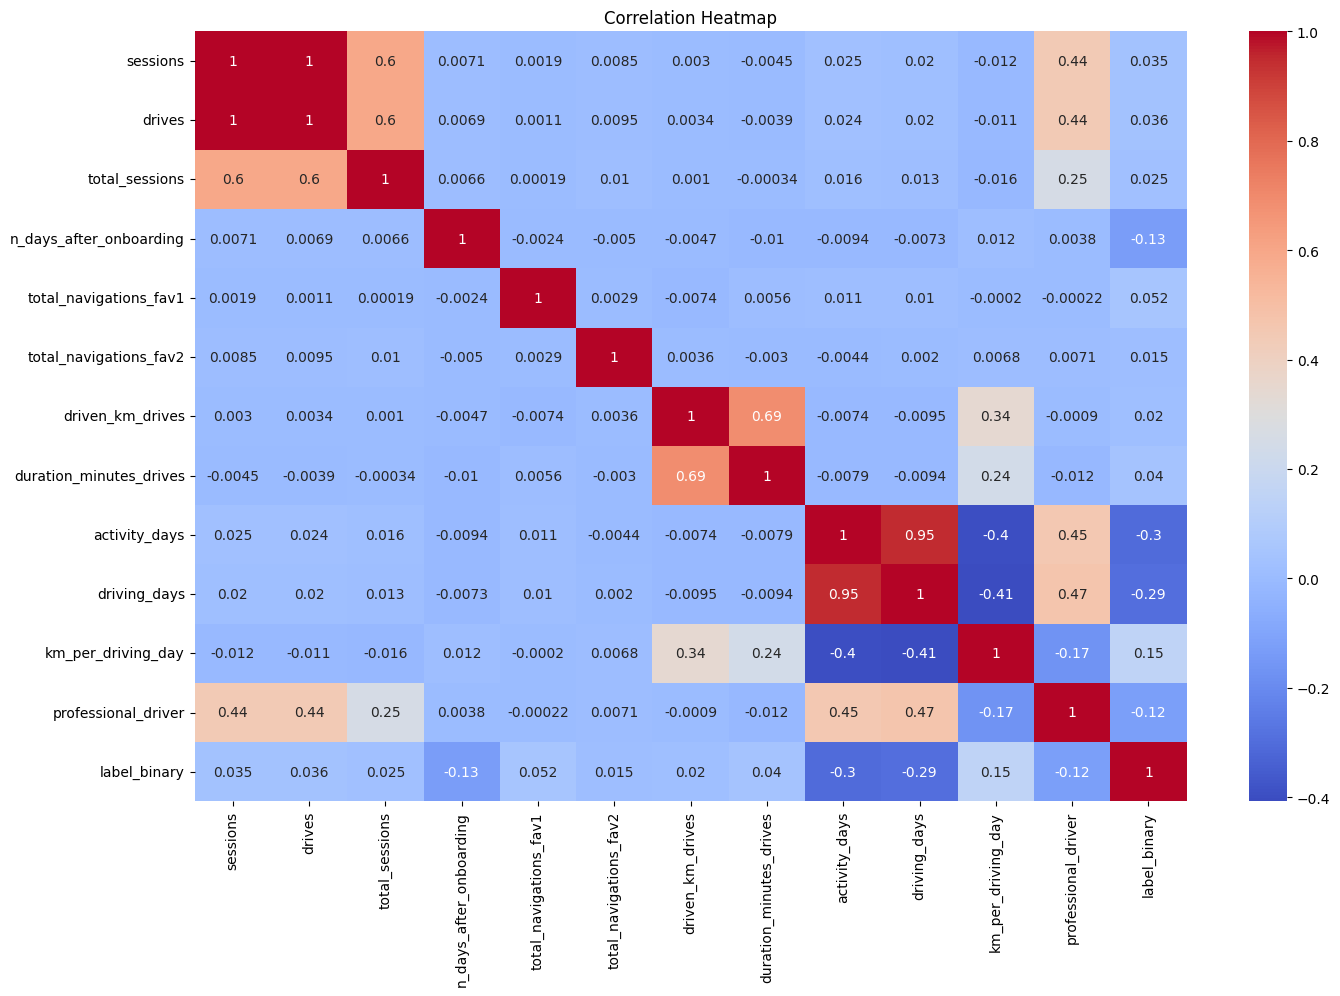

In [67]:
plt.figure(figsize=(16,10))
sns.heatmap(
    numeric_df.corr(method='pearson'),
    annot=True,
    cmap='coolwarm')
plt.title('Correlation Heatmap')

`sessions` and `drives` have a pearson correlation coefficient of 1.0 and `driving_days` and `activity_days` have a coefficent of 0.95. These variables are strongly multicolinear and so we should only use one variable from each pair. 

In [68]:
# create new device_binary variable
df['device_binary'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device_binary']].tail()

,device,device_binary
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


#### Model Building

In [69]:
# assign variables
X = df[['drives', 'total_sessions', 'n_days_after_onboarding',
       'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
       'duration_minutes_drives', 'activity_days', 'km_per_driving_day',
       'professional_driver', 'device_binary']]

y = df['label_binary']

In [74]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# instatiate logistic regression model
model = LogisticRegression(penalty=None, max_iter=400)

model.fit(X_train, y_train)

C:\Users\mqtth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=400, penalty=None)

In [ ]:
# get coefficients
pd.Series(model.coef_[0], index=X.columns)

drives                     0.001939
total_sessions             0.000362
n_days_after_onboarding   -0.000401
total_navigations_fav1     0.001254
total_navigations_fav2     0.000990
driven_km_drives          -0.000013
duration_minutes_drives    0.000110
activity_days             -0.105261
km_per_driving_day         0.000019
professional_driver       -0.007963
device_binary              0.023930
dtype: float64

In [76]:
# get predicted probabilities form training data
training_prob = model.predict_proba(X_train)
training_prob

array([[0.93732719, 0.06267281],
       [0.62203943, 0.37796057],
       [0.766742  , 0.233258  ],
       ...,
       [0.91802934, 0.08197066],
       [0.84877287, 0.15122713],
       [0.93327236, 0.06672764]])

The log-odds (logit) of the dependent variable with respect to the predictor variable should be linear. Here is the formula:

$$
\text{logit}(p) = \ln\left(\frac{p}{1 - p}\right)
$$

In [77]:
# xopy X_train df
logit_data = X_train.copy()

# create new logit column
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_prob]

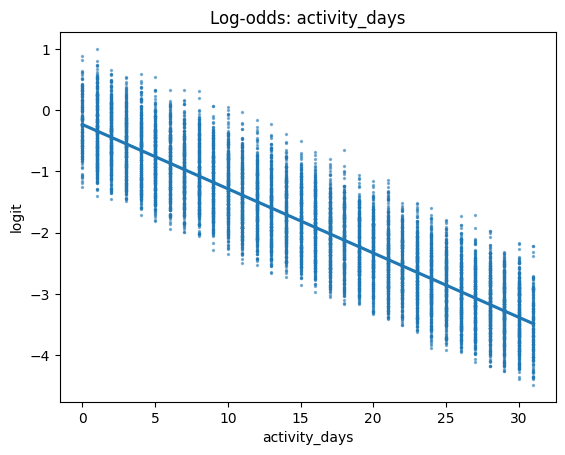

In [ ]:
# plot regplot
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days')

In [80]:
# get predictions
y_preds = model.predict(X_test)

# calculate model accuracy
model.score(X_test, y_test)

0.8243356643356643

#### Showing results with a confusion matrix

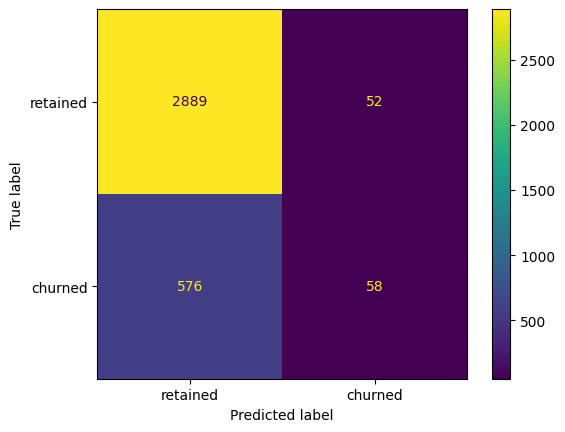

In [ ]:
cm = confusion_matrix(y_test, y_preds)

# display confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=['retained', 'churned'],
)

disp.plot()

In [82]:
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))


              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.53      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



This model has medicore precision and very low recall. This means that it makes a lot of false negative predictions and struggles to capture users who will churn. 